In [1]:
from algorithm import learn
from common import SystemConfig
from dynamics import ContinuousLQREnv

import matplotlib.pyplot as plt
import numpy as np

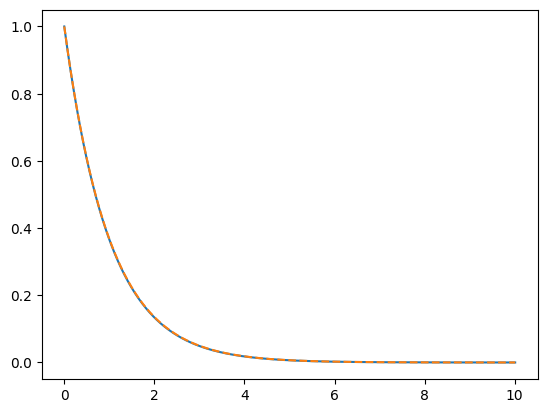

In [2]:
# Sanity check: x'(t) = -x(t) should give exp(-t)
A = np.array([[-1.0]])
B = np.array([[0.0]])
sigma = np.array([[0.0]])
x0 = np.array([1.0])
config = SystemConfig(x_dim=1, u_dim=1, dt=0.01, T=10)
env = ContinuousLQREnv(A, B, sigma, x0, config)
t_vals = [env.t]
x_vals = [x0.item()]
t = 0.0

while t < config.T:
    t += config.dt
    x, _, _ = env.step(np.array([0.0]))
    t_vals.append(t)
    x_vals.append(x.item())

plt.plot(t_vals, x_vals)
plt.plot(t_vals, np.exp(-np.array(t_vals)), linestyle='--')

In [3]:
def report_results(results):
    plt.figure()
    plt.plot(np.cumsum(results["regrets"]))
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Regret")
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(np.cumsum(results["regrets"])[2:])
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Regret")
    plt.grid()
    plt.show()

    A, B = results["thetas"][-1]
    print("Estimated A:", A)
    print("Estimated B:", B)

Cycle | Episodes | Param Error  | Avg Cost  
---------------------------------------------
0     | 1        | 1.3120       | 37.79     
1     | 2        | 0.1133       | 2.97      
2     | 4        | 0.0492       | 3.35      
3     | 8        | 0.1053       | 3.50      
4     | 16       | 0.1276       | 3.59      


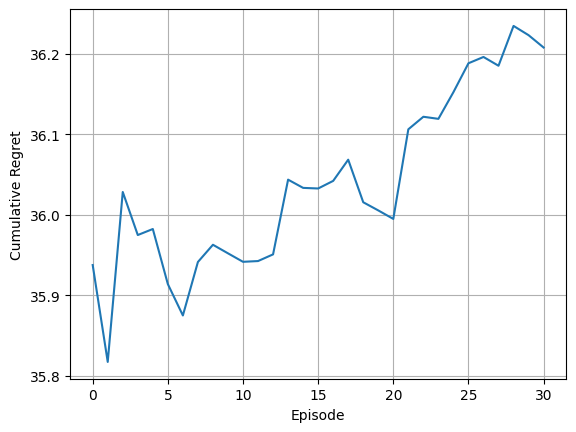

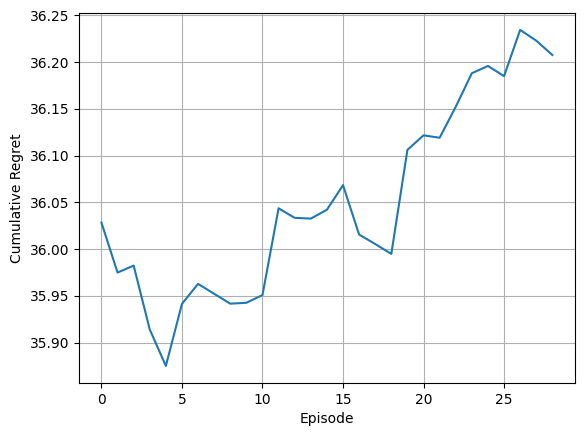

Estimated A: [[0.44775101]]
Estimated B: [[0.92465181]]


In [4]:
# Simple Scalar System: dx = (0.5x + u)dt + 0.1dw
config = SystemConfig(
    x_dim=1,
    u_dim=1,
    dt=0.001,
    T=5.0
)
A = np.array([[0.5]])
B = np.array([[1.0]])
sigma = np.array([[0.5]])
x0 = np.array([1.0])
Q = np.array([[1.0]])
R = np.array([[1.0]])

results = learn(A, B, sigma, x0, Q, R, config, cycles=5)
report_results(results)

Cycle | Episodes | Param Error  | Avg Cost  
---------------------------------------------
0     | 1        | 0.9974       | 124.64    
1     | 2        | 0.0949       | 8.15      
2     | 4        | 0.0479       | 7.99      
3     | 8        | 0.0357       | 7.86      
4     | 16       | 0.0337       | 7.55      
5     | 32       | 0.0464       | 7.53      
6     | 64       | 0.0224       | 7.84      
7     | 128      | 0.0225       | 7.66      
8     | 256      | 0.0309       | 7.67      
9     | 512      | 0.0291       | 7.68      


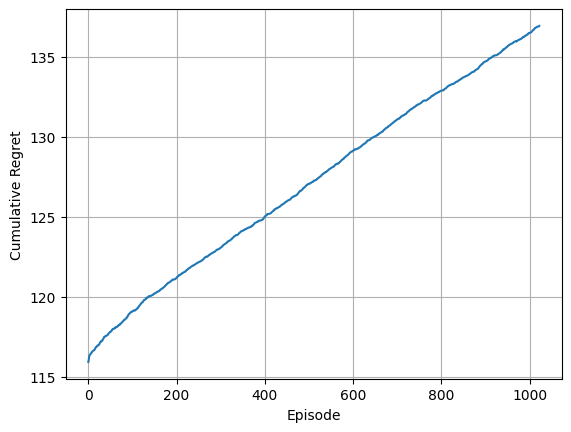

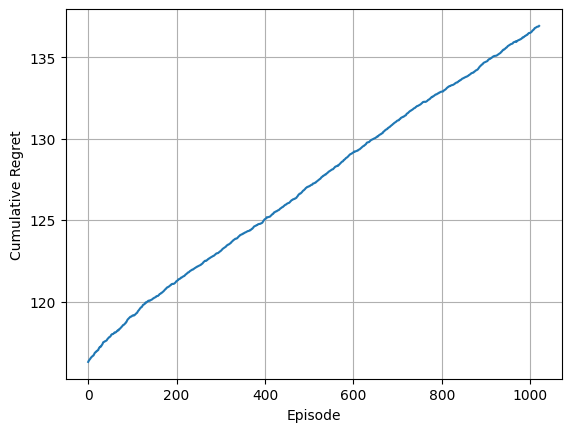

Estimated A: [[0.00674656 1.01836164]
 [0.00305439 0.00602491]]
Estimated B: [[0.00813027]
 [1.00201026]]


In [9]:
# Double Integrator: ds = v dt + 0.1dw, dv = u dt + 0.1dw
config = SystemConfig(
    x_dim=2,
    u_dim=1,
    dt=0.1,
    T=10.0
)
A = np.array([[0.0, 1.0], [0.0, 0.0]])
B = np.array([[0.0], [1.0]])
sigma = 0.1 * np.eye(2) # significant process noise
x0 = np.array([2.0, 0.0])  # Start away from origin to force the agent to act
Q = np.eye(2)
R = np.eye(1)

results = learn(A, B, sigma, x0, Q, R, config, cycles=10)
report_results(results)

Cycle | Episodes | Param Error  | Avg Cost  
---------------------------------------------
0     | 1        | 62.4594      | 1793.62   
1     | 2        | 11.1489      | 12.75     
2     | 4        | 3.4674       | 6.29      
3     | 8        | 1.8949       | 6.84      
4     | 16       | 1.4380       | 7.20      
5     | 32       | 1.0589       | 9.45      
6     | 64       | 0.5778       | 10.33     
7     | 128      | 0.6122       | 9.51      
8     | 256      | 0.2991       | 9.70      
9     | 512      | 0.2762       | 9.16      


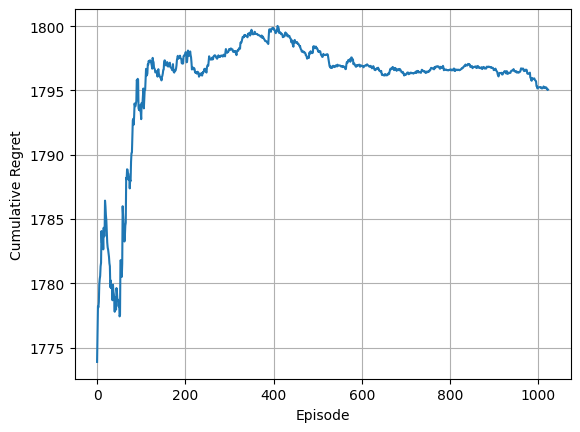

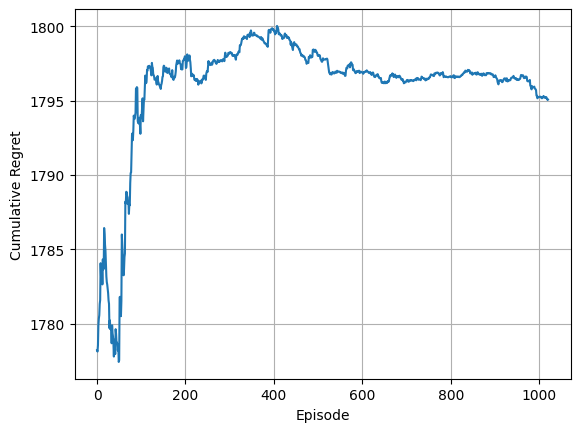

Estimated A: [[-4.01240334e-02  1.00041100e+00 -1.90657655e-01 -1.20950913e-02]
 [ 3.06119458e-02 -3.84955729e-02  9.26074030e-01  3.00511394e-02]
 [-6.76279686e-02 -1.00950185e-02 -8.73917626e-02  1.01303435e+00]
 [-6.71869100e-02  3.41123994e-03  2.16863753e+01 -2.67616339e-04]]
Estimated B: [[-0.00620234]
 [ 1.00181814]
 [-0.00267058]
 [ 1.99827762]]


In [10]:
# 4D Cart-Pole System (Linearized at upright unstable equilibrium)
config = SystemConfig(
    x_dim=4,
    u_dim=1,
    dt=0.01,
    T=1.0
)

# Derives from the Jacobian of the equations of motion.
A = np.array([
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.981, 0.0],
    [0.0, 0.0, 0.0, 1.0],
    [0.0, 0.0, 21.582, 0.0]
])

# Force only enters the cart velocity and pole angular velocity.
B = np.array([
    [0.0],
    [1.0],
    [0.0],
    [2.0]
])

# Sigma: Process noise (wind/friction disturbances)
sigma = np.eye(4) * 0.5 

x0 = np.array([0.0, 0.0, 0.1, 0.0]) # Start slightly off-balance

# Q and R: Penalize pole angle heavily, cart position moderately.
Q = np.diag([10.0, 1.0, 100.0, 1.0])
R = np.array([[0.1]]) # Cheap control

results = learn(A, B, sigma, x0, Q, R, config, cycles=10, m0=1, exploration_scale=0.05)
report_results(results)

Cycle | Episodes | Param Error  | Avg Cost  
---------------------------------------------
0     | 1        | 7.9284       | 21750.93  
1     | 2        | 0.0056       | 889061036614.31
2     | 4        | 0.0053       | 17.03     
3     | 8        | 0.0054       | 18.68     
4     | 16       | 0.0049       | 17.09     
5     | 32       | 0.0054       | 16.85     
6     | 64       | 0.0054       | 17.21     
7     | 128      | 0.0047       | 17.19     
8     | 256      | 0.0058       | 17.11     
9     | 512      | 0.0060       | 17.15     


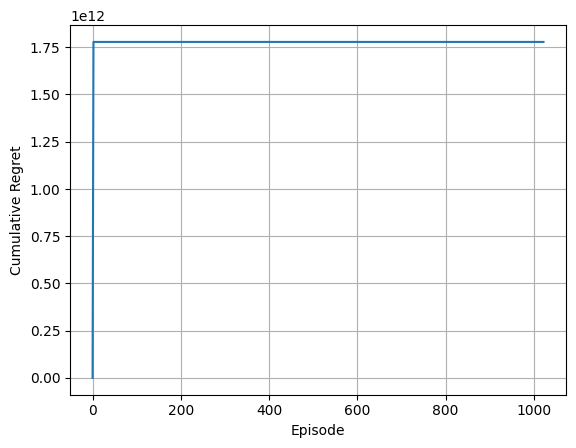

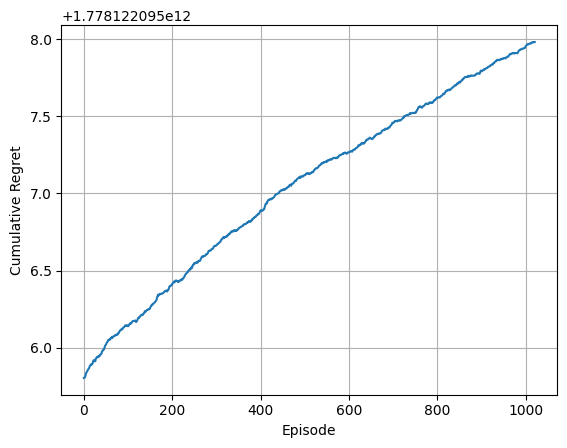

Estimated A: [[-2.33162391e-03 -6.63716597e-04  1.23257149e-03  1.00092354e+00
   1.45583436e-04 -4.46976248e-05]
 [ 1.05616746e-03 -9.32086956e-06  1.10310460e-05 -1.83835841e-04
   1.00015654e+00 -1.79621993e-05]
 [-7.12811755e-04 -7.19001516e-05  2.81486033e-04  1.85174213e-04
  -6.37993699e-05  9.99998308e-01]
 [ 4.06244793e-03  7.99811251e-04 -9.81163608e+00 -1.37506272e-03
  -1.83763419e-06  4.38673819e-05]
 [ 1.46957725e-03  3.02864535e-04 -6.77444110e-04 -5.44057371e-04
  -2.31883786e-05  2.07438343e-05]
 [-7.95783605e-04 -5.64242817e-05  2.33929491e-04  2.16390119e-04
  -7.11560129e-05 -5.59427580e-06]]
Estimated B: [[-3.73045243e-05  5.18654367e-06]
 [-2.99892326e-05  6.00237167e-06]
 [-1.39601676e-06  8.20097342e-06]
 [ 2.31697297e-05 -1.01055083e-05]
 [ 1.00001644e+00  9.99991962e-01]
 [-2.49999948e+01  2.50000065e+01]]


In [12]:
# 6D Planar Quadrotor System (Linearized at hover)
config = SystemConfig(
    x_dim=6,
    u_dim=2,
    dt=0.01,
    T=5.0
)

# A_true: Roll angle (theta) dictates lateral acceleration (y_ddot).
A = np.zeros((6, 6))
A[0, 3] = 1.0  # y_dot
A[1, 4] = 1.0  # z_dot
A[2, 5] = 1.0  # theta_dot
A[3, 2] = -9.81 # y_ddot = -g * theta (Gravity projection)

# B_true: Thrust inputs (u1, u2) affect altitude (z_ddot) and roll (theta_ddot).
B = np.zeros((6, 2))
B[4, 0] = 1.0  # z_ddot += u1 / m (m=1)
B[4, 1] = 1.0  # z_ddot += u2 / m
B[5, 0] = -25.0 # theta_ddot -= u1 * L / I
B[5, 1] = 25.0  # theta_ddot += u2 * L / I

sigma = np.eye(6) * 0.1
x0 = np.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0]) # Start 1m away and 1m up

Q = np.diag([10.0, 10.0, 50.0, 1.0, 1.0, 1.0])
R = np.eye(2) * 0.5

results = learn(A, B, sigma, x0, Q, R, config, cycles=10, m0=1, exploration_scale=0.05)
report_results(results)